<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [1]:
import tensorflow as tf

inputs = tf.keras.Input(shape=(28, 28), dtype=tf.float32)
h = tf.keras.layers.Rescaling(scale=1./255)(inputs)
outputs = tf.keras.layers.Reshape(target_shape=(784,))(h)
preprocessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [2]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=64)
    ds = ds.map(map_func=lambda x, y: (preprocessing_model(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [6]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

inputs = tf.keras.Input(shape=(784,))
h = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs)
h = tf.keras.layers.Dropout(rate=0.2)(h)
outputs = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)(h)
training_model = tf.keras.Model(inputs=inputs, outputs=outputs)
training_model.summary()

training_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import tensorflow as tf

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = training_model(inputs=x, training=True)
        loss = training_model.compute_loss(y=y, y_pred=y_pred)

    grads = tape.gradient(target=loss,
        sources=training_model.trainable_variables)
    training_model.optimizer.apply_gradients(grads_and_vars=zip(
        grads, training_model.trainable_variables))

    for m in training_model.metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)

@tf.function
def test_step(x, y):
    y_pred = training_model(inputs=x, training=False)
    loss = training_model.compute_loss(y=y, y_pred=y_pred)

    for m in training_model.metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)

In [15]:
import time
import tensorflow as tf

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    patience=1, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList(model=training_model,
    add_history=True, callbacks=[reduce_lr])

logs = {}
callbacks.on_train_begin(logs=logs)
num_epochs = 10
history = []
start_time = time.time()

for epoch in range(num_epochs):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for x, y in ds_train:
        train_step(x=x, y=y)

    for m in training_model.metrics:
        if m.name=="loss":
            logs[f"train_{m.name}"] = float(m.result())
        else:
            for k, v in m.result().items():
                logs[f"train_{k}"] = float(v)
        m.reset_state()

    for x, y in ds_test:
        test_step(x=x, y=y)

    for m in training_model.metrics:
        if m.name=="loss":
            logs[f"test_{m.name}"] = float(m.result())
        else:
            for k, v in m.result().items():
                logs[f"test_{k}"] = float(v)
        m.reset_state()

    callbacks.on_epoch_end(epoch=epoch, logs=logs)
    history.append(logs)

callbacks.on_train_end(logs=logs)
print("Training duration: %2.fs"%(time.time() - start_time))

Training duration: 38s


In [17]:
df_history

,train_loss,train_accuracy,test_loss,test_accuracy,learning_rate,epoch
0,0.066003,0.980817,0.085848,0.9792,0.000531,1
1,0.066003,0.980817,0.085848,0.9792,0.000531,2
2,0.066003,0.980817,0.085848,0.9792,0.000531,3
3,0.066003,0.980817,0.085848,0.9792,0.000531,4
4,0.066003,0.980817,0.085848,0.9792,0.000531,5
5,0.066003,0.980817,0.085848,0.9792,0.000531,6
6,0.066003,0.980817,0.085848,0.9792,0.000531,7
7,0.066003,0.980817,0.085848,0.9792,0.000531,8
8,0.066003,0.980817,0.085848,0.9792,0.000531,9
9,0.066003,0.980817,0.085848,0.9792,0.000531,10


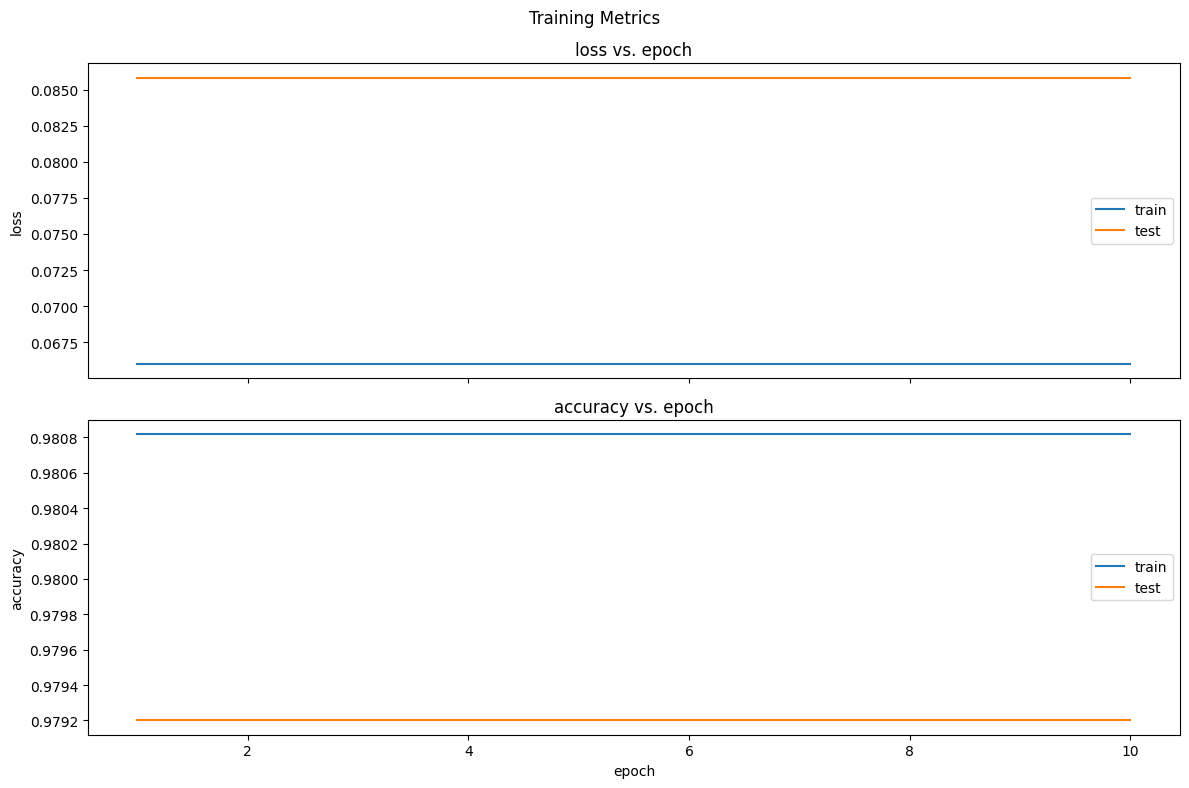

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9759 - loss: 0.1015
Test loss: 0.09, Test accuracy: 0.98


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
fig.suptitle(t="Training Metrics")
axes[1].set_xlabel(xlabel="epoch")
for ax, m in zip(axes, ["loss", "accuracy"]):
    g = sns.lineplot(ax=ax, data=df_history, label="train",
        x="epoch", y=f"train_{m}")
    g = sns.lineplot(ax=ax, data=df_history, label="test",
        x="epoch", y=f"test_{m}")
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

loss, acc = training_model.evaluate(x=ds_test)
print(f"Test loss: {loss:.2f}, Test accuracy: {acc:.2f}")

In [ ]:
import os
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs=inputs, outputs=outputs)
os.makedirs("models", exist_ok=True)
inference_model.save(filepath="model/model.keras")

idx = 99
x_pred = np.reshape(a=x_test[idx], newshape=(1, 28, 28))
inference_model = tf.keras.models.load_model(
    filepath="model/model.keras")
y_pred = inference_model(x_pred)
print("y_true:", y_test[idx], "y_pred:", np.argmax(y_pred))

In [ ]:
import keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

@keras.saving.register_keras_serializable()
class CustomModel(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dense_1 = tf.keras.layers.Dense(units=64,
            activation=tf.keras.activations.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))
        self.dropout = tf.keras.layers.Dropout(rate=0.2)
        self.dense_2 = tf.keras.layers.Dense(units=10,
            activation=tf.keras.activations.softmax)

    def call(self, inputs, training=False):
        h = self.dense_1(inputs=inputs)
        h = self.dropout(inputs=h, training=training)
        return self.dense_2(inputs=h)

    @tf.function
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(inputs=x, training=True)
            loss = self.compute_loss(y=y, y_pred=y_pred)

        grads = tape.gradient(target=loss, sources=self.trainable_variables)
        self.optimizer.apply_gradients(grads_and_vars=zip(
            grads, self.trainable_variables))

        for m in self.metrics:
            if m.name=='loss':
                m.update_state(values=loss)
            else:
                m.update_state(y_true=y, y_pred=y_pred)

        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        x, y = data

        y_pred = self(inputs=x, training=False)
        loss = self.compute_loss(y=y, y_pred=y_pred)

        for m in self.metrics:
            if m.name=='loss':
                m.update_state(values=loss)
            else:
                m.update_state(y_true=y, y_pred=y_pred)

        return {f'{m.name}': m.result() for m in self.metrics}

training_model = CustomModel()
training_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

In [ ]:
import time
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

start_time = time.time()
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
    patience=1, factor=0.9)
history = training_model.fit(x=ds_train, validation_data=ds_test,
    epochs=10, callbacks=[reduce_lr])
training_model.summary()
print('Training duration: %.2fs'%(time.time() - start_time))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7968 - loss: 0.6892 - val_accuracy: 0.9399 - val_loss: 0.1983 - learning_rate: 0.0010
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9327 - loss: 0.2367 - val_accuracy: 0.9568 - val_loss: 0.1511 - learning_rate: 0.0010
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9458 - loss: 0.1880 - val_accuracy: 0.9606 - val_loss: 0.1296 - learning_rate: 0.0010
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9531 - loss: 0.1599 - val_accuracy: 0.9663 - val_loss: 0.1158 - learning_rate: 0.0010
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9589 - loss: 0.1399 - val_accuracy: 0.9675 - val_loss: 0.1069 - learning_rate: 0.0010
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9625 - loss: 0.1258 - val_accuracy: 0.9713 - val_loss: 0.1028 - learning_rate: 0.0010
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9644 - loss: 0.1169 - 

Model: "custom_model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,672 (596.38 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,782 (397.59 KB)

Training duration: 15.44s


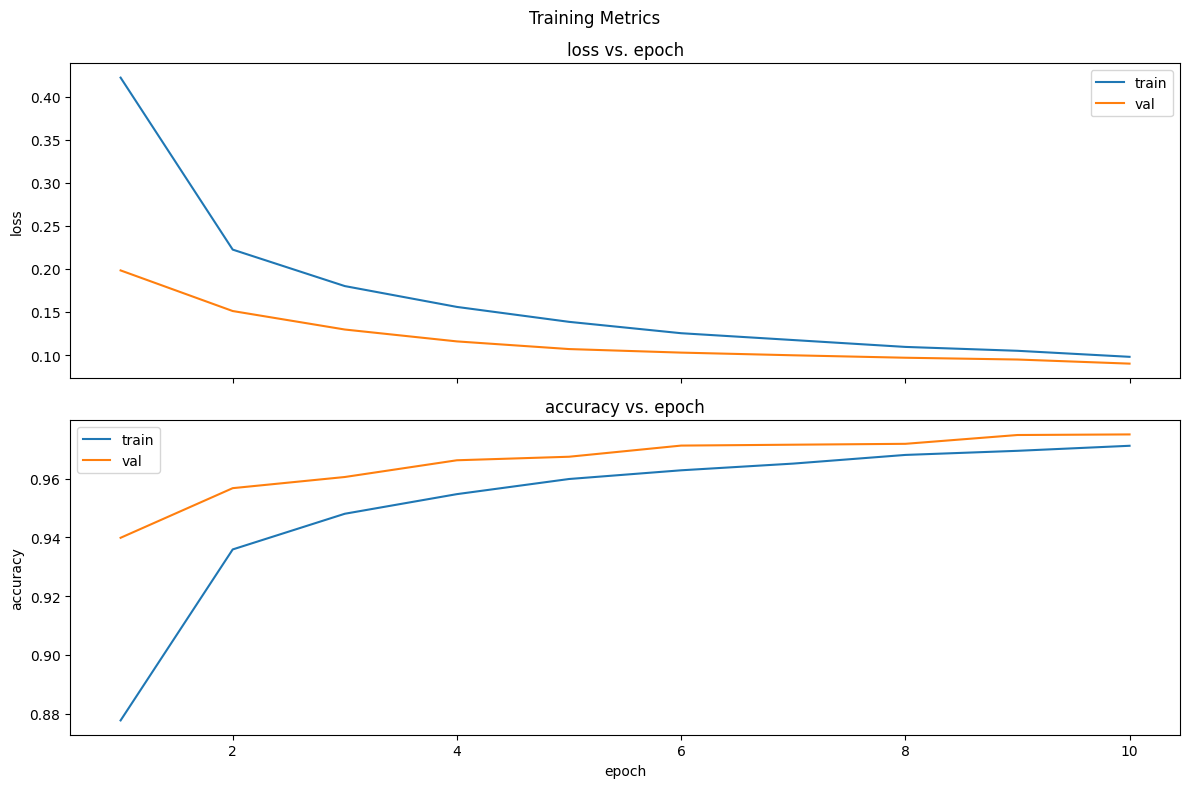

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.9723 - loss: 0.1026
Test loss: 0.09, Test accuracy: 0.98


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_history = pd.DataFrame(history.history)
df_history['epoch'] = df_history.index + 1

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
fig.suptitle(t='Training Metrics')
axes[1].set_xlabel(xlabel='epoch')
for ax, m in zip(axes, ["loss", "accuracy"]):
    g = sns.lineplot(ax=ax, data=df_history, label='train',
        x='epoch', y=f'{m}')
    g = sns.lineplot(ax=ax, data=df_history, label='val',
        x='epoch', y=f'val_{m}')
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

loss, acc = training_model.evaluate(x=ds_test)
print(f'Test loss: {loss:.2f}, Test accuracy: {acc:.2f}')

In [ ]:
import os
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs=inputs, outputs=outputs)
os.makedirs('models', exist_ok=True)
inference_model.save('models/model.keras')

idx = 99
x_pred = np.reshape(a=x_test[idx], newshape=(1, 28, 28))
inference_model = tf.keras.models.load_model('models/model.keras')
y_pred = inference_model(x_pred)
print('y_true:', y_test[idx], 'y_pred:', np.argmax(y_pred))

y_true: 9 y_pred: 9
